In [1]:
from PhasePicker import PickerNet
from PhasePickerTraining import Picker
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import os
from PhaseNetPicker import PhaseNetPicker
from SWAG import SWAGInference
import h5py
os.chdir("/Users/noahliniger/Documents/GitHub/earthquake-monitoring")
from models.PhaseNet import PhaseNetL
from tqdm import tqdm


# Loading the model, dataloaders etc.

In [2]:
checkpoint = torch.load('/Users/noahliniger/Documents/GitHub/earthquake-monitoring/ContinuedTraining.pth')
model = PhaseNetPicker()
model.load_state_dict(checkpoint['model_state'])
csv_files = ['/Users/noahliniger/Downloads/chunk2/chunk2.csv', '/Users/noahliniger/Downloads/chunk3/chunk3.csv', '/Users/noahliniger/Downloads/chunk4/chunk4.csv',\
                '/Users/noahliniger/Downloads/chunk5/chunk5.csv', '/Users/noahliniger/Downloads/chunk6/chunk6.csv'] 
h5_files = ['/Users/noahliniger/Downloads/chunk2/chunk2.hdf5', '/Users/noahliniger/Downloads/chunk3/chunk3.hdf5', '/Users/noahliniger/Downloads/chunk4/chunk4.hdf5',\
                '/Users/noahliniger/Downloads/chunk5/chunk5.hdf5', '/Users/noahliniger/Downloads/chunk6/chunk6.hdf5'] 
picker = Picker(csv_files=csv_files, h5_files=h5_files, model=model)
print("Creating the data loaders...")
train_loader, test_loader, valid_loader = picker.createDataLoaders(frac_train=0.7, frac_test=0.15, batch_size=32, return_snr=False, input_length=5864)
print("Created the data loaders...")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

#classifier = torch.load('/Users/noahliniger/Documents/GitHub/earthquake-monitoring/classification_tolga/phasenet_15epochs.pt')
#classifier.to(device)

Device: mps
Creating the data loaders...
Created the data loaders...


PhaseNetPicker(
  (inc): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
     

In [3]:
#Wrapper around the classifier:
# class MyModelWrapper(nn.Module):
#     def __init__(self, model, device):
#         super(MyModelWrapper, self).__init__()
#         self.model = model
#         self.model.to(device)

#     def forward(self, x):
#         x = x.squeeze(1)
#         output = self.model(x)  # Assuming output shape is [32, 3, 5864]
#         final_output = torch.zeros(output.size(0), 2)
#         final_output[:,0] = torch.argmax(output[:,0,:], dim=1)
#         final_output[:,1] = torch.argmax(output[:,1,:], dim=1)
#         return final_output

# MaxRegressor = MyModelWrapper(classifier, device=device).to(device)

NameError: name 'classifier' is not defined

In [19]:
# Plotting function:
def plotPredictions(waves, predictions, labels, min: int = 100, max: int = 5000):

    x = np.linspace(start=min, stop=max, num=max-min)

    for i in range(32):
        # Creating the primary axis for the wave and vertical lines
        fig, ax1 = plt.subplots(figsize=(20, 6))

        # Plotting the wave
        ax1.plot(x, waves[i,0,min:max], 'k')
        ax1.set_xlabel('Time (s)', fontsize=16)
        ax1.set_ylabel('Density', color='k', fontsize=16)
        ax1.tick_params(axis='both', which='major', labelsize=14)

        #P wave
        map_value = np.mean(predictions[i,0,:])
        true_label = labels[i,0]

        ax1.vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean Prediction P", linewidth=3) #linestyles="--")
        ax1.vlines(true_label, ymax=1, ymin=0, colors="b", label="True P", linewidth=3) #linestyles="--")

        stdP = np.std(predictions[i,0,:])
        ax1.vlines(map_value + stdP, ymax=1, ymin=0, colors="gray", label="$\pm$ Standard Deviation", linewidth=3, linestyles="--")
        ax1.vlines(map_value - stdP, ymax=1, ymin=0, colors="gray", linewidth=3, linestyles="--")


        #S wave
        map_value = np.mean(predictions[i,1,:])
        true_label = labels[i,1]

        ax1.vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean Prediction S",linewidth=3) #linestyles="--")
        ax1.vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S", linewidth=3) #linestyles="--") 

        stdS = np.std(predictions[i,1,:])
        ax1.vlines(map_value + stdS, ymax=1, ymin=0, colors="pink", linewidth=3, linestyles="--")
        ax1.vlines(map_value - stdS, ymax=1, ymin=0, colors="pink", linewidth=3, linestyles="--")


        ax1.hist(predictions[i,0,:], bins=5, color='gray', density=True)
        ax1.hist(predictions[i,1,:], bins=5, color='pink', density=True)


        # Adding legend and showing the plot
        ax1.legend(fontsize=14)
        fig.tight_layout()
        plt.show()

# SWAG

In [4]:
swag = SWAGInference(model=model, train_loader=train_loader, test_loader=test_loader, bma_samples=30, swag_learning_rate=1e-18, deviation_matrix_max_rank=20, swag_update_freq=5)
swag.fit_swag(num_training_batches = 100)
bma_probabilities, per_model_sample_predictions = swag.predict_probabilities_swag(num_eval_batches=1)

Performing Bayesian model averaging: 100%|██████████| 30/30 [15:56<00:00, 31.88s/it]


In [9]:
processed_samples = 0
average_loss = 0
for waves, labels in tqdm(valid_loader):
    waves = waves.to(device)
    loss = torch.nn.MSELoss()
    output = model(waves).cpu()
    batch_loss = loss(output, labels)
    average_loss = (waves.size(0) * batch_loss + processed_samples * average_loss)/(processed_samples + waves.size(0))
    processed_samples += waves.size(0)

# plotPredictions(min = 0, max = 5000, predictions=torch.stack(per_model_sample_predictions).reshape(32, 2, -1).cpu().detach().numpy(), waves=waves.cpu().detach().numpy(), labels=labels.cpu().detach().numpy())

  0%|          | 0/4830 [00:08<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 17.83 GB, other allocations: 321.69 MB, max allowed: 18.13 GB). Tried to allocate 733.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

tensor(3477.1033, grad_fn=<ToCopyBackward0>)


/var/folders/5n/18n_fhb51msczhxf4c8mqcvm0000gn/T/ipykernel_1588/829333600.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(20, 5))


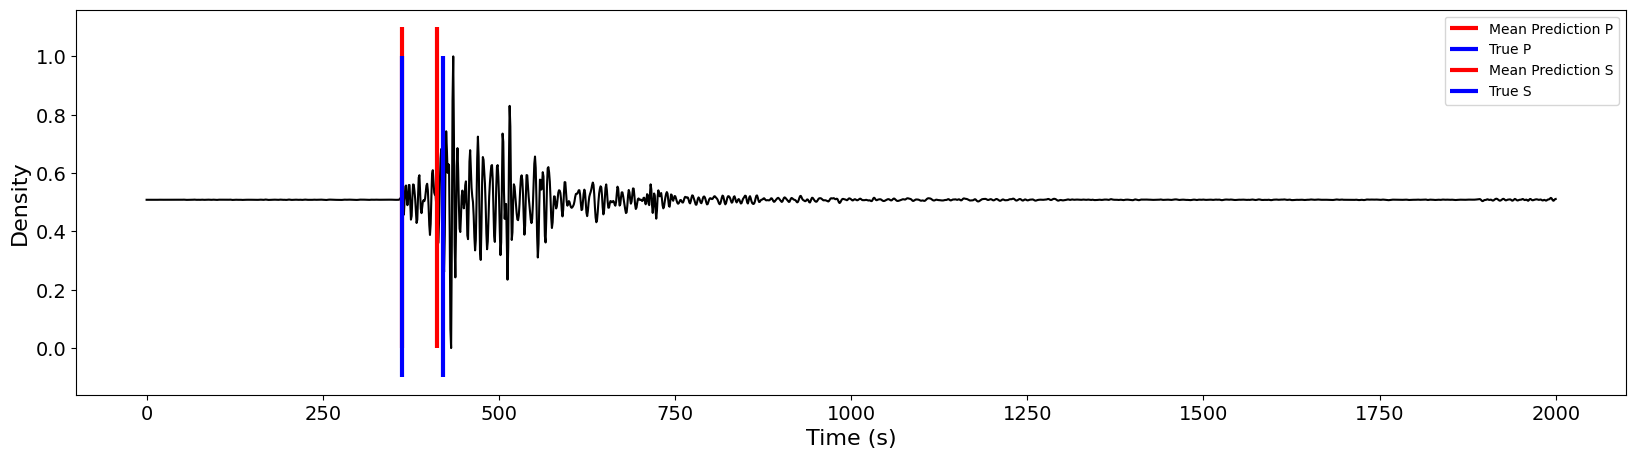

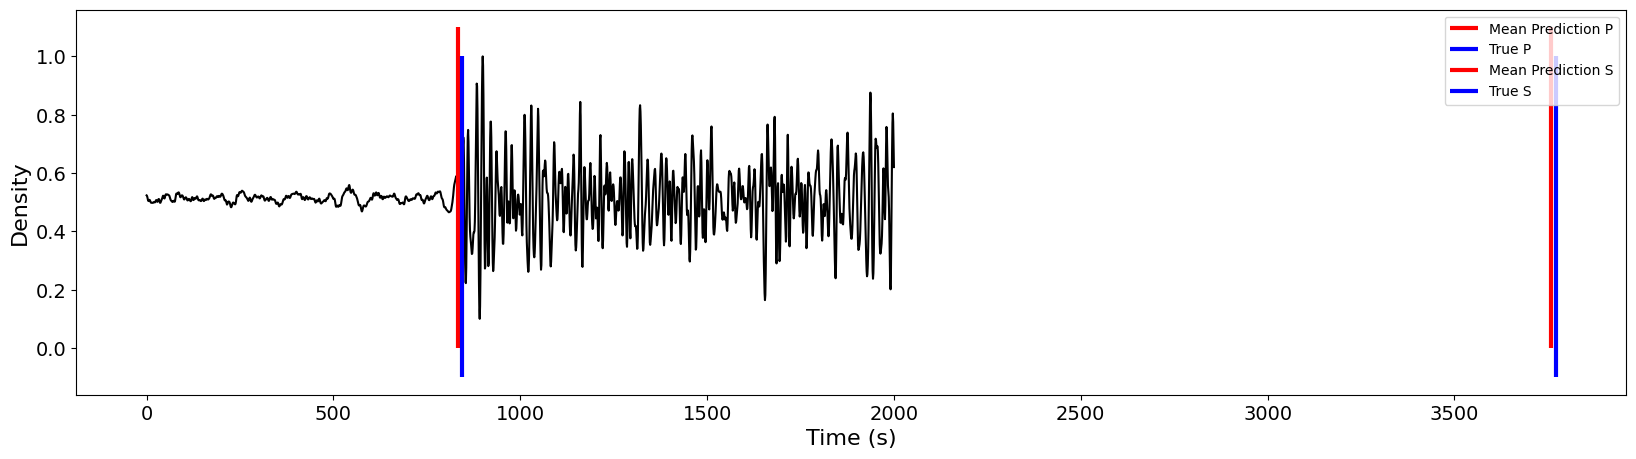

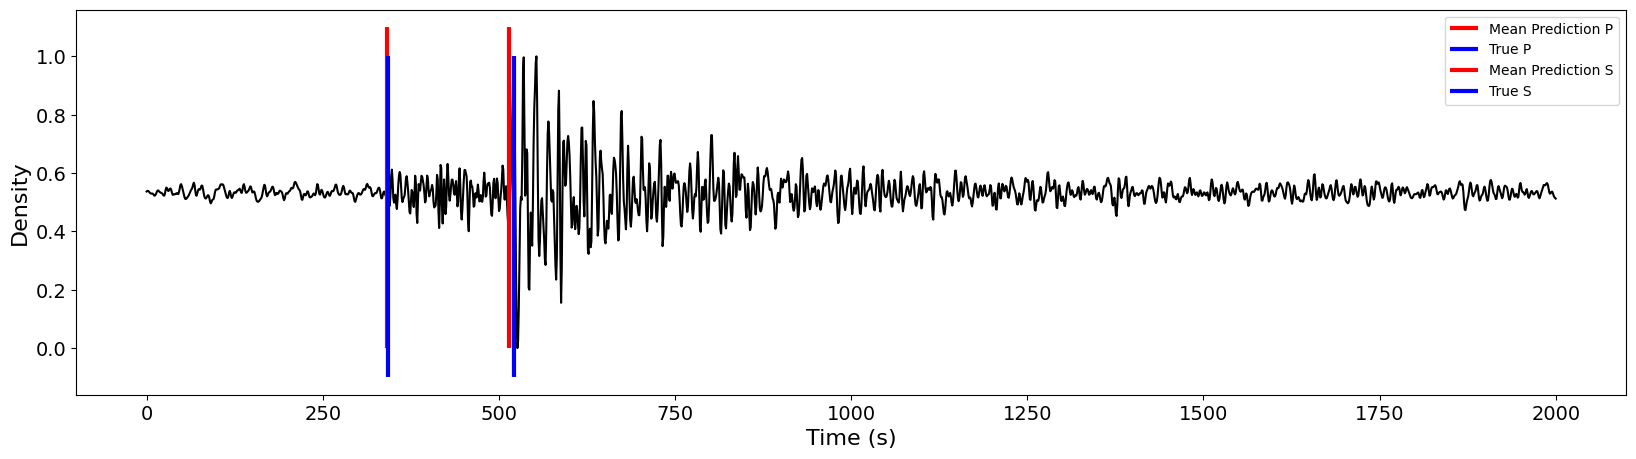

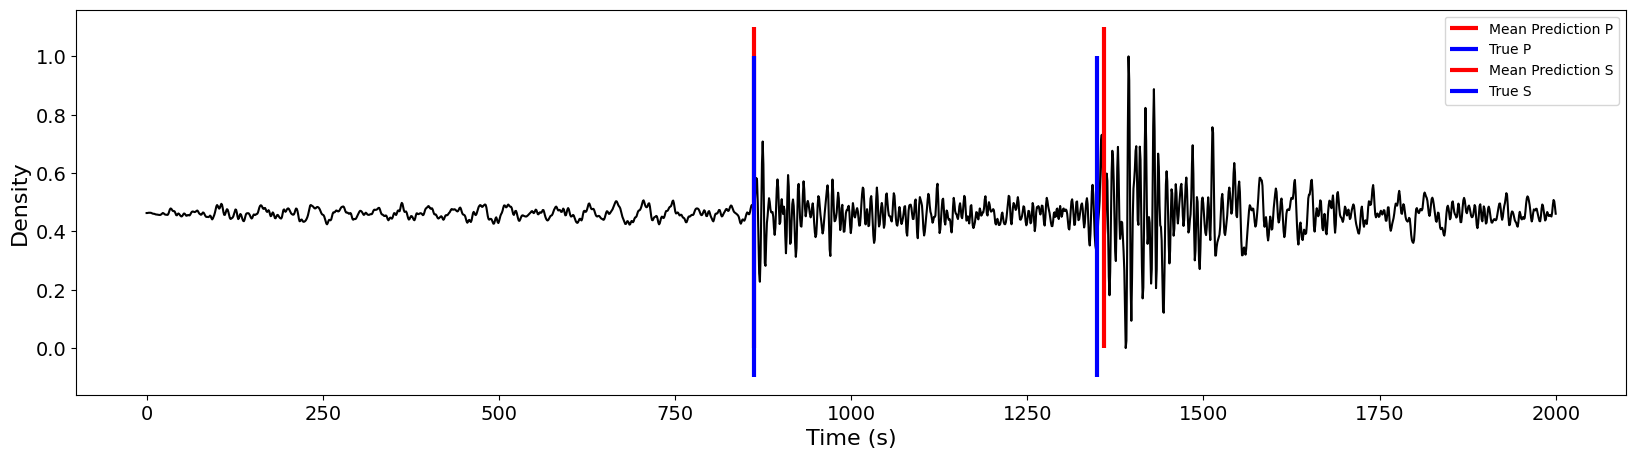

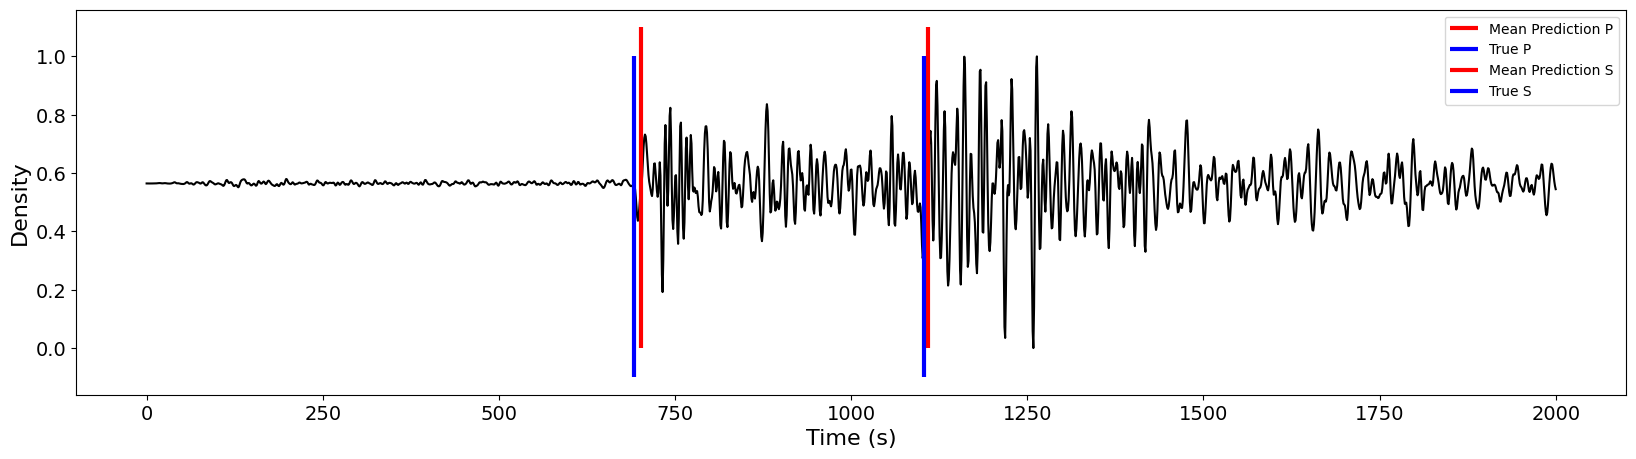

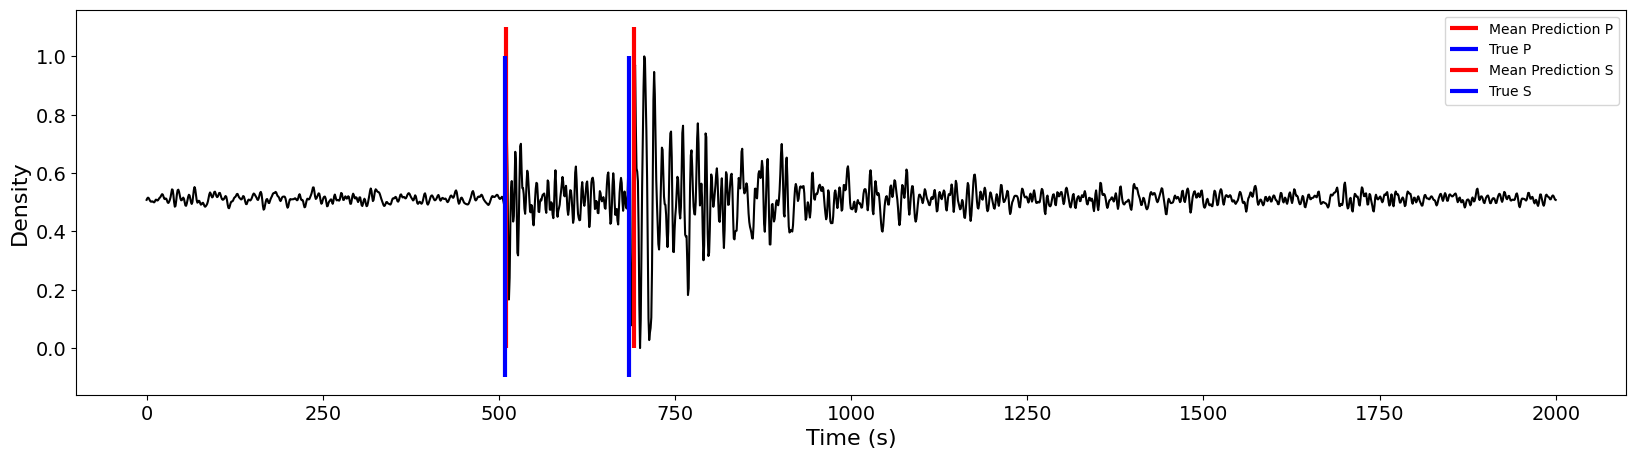

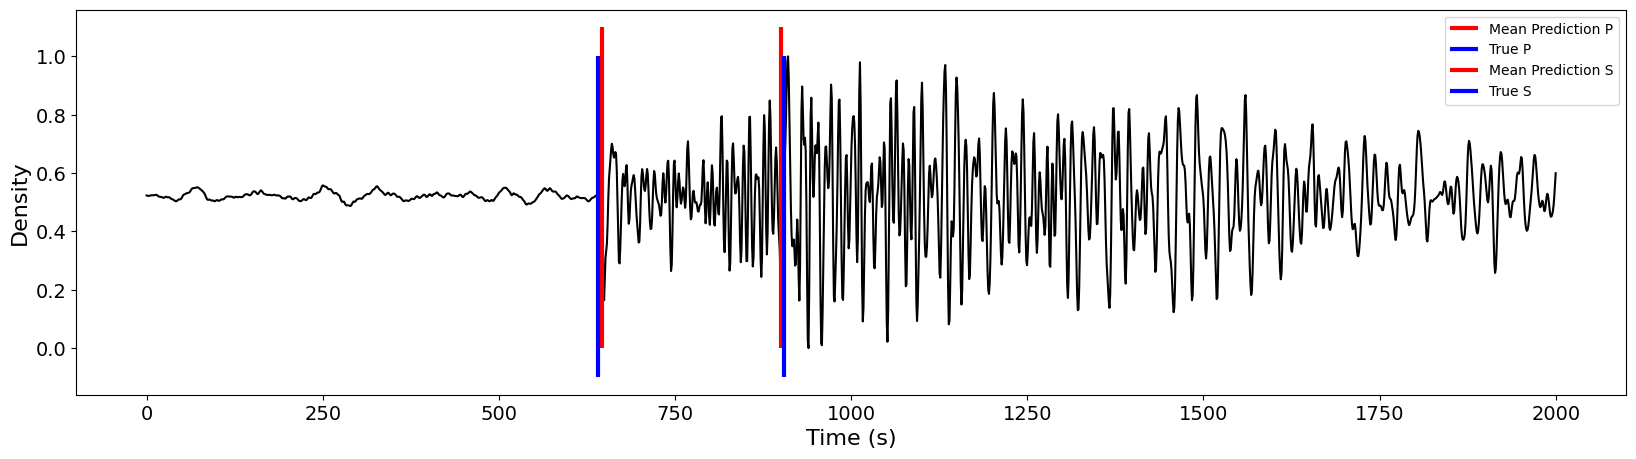

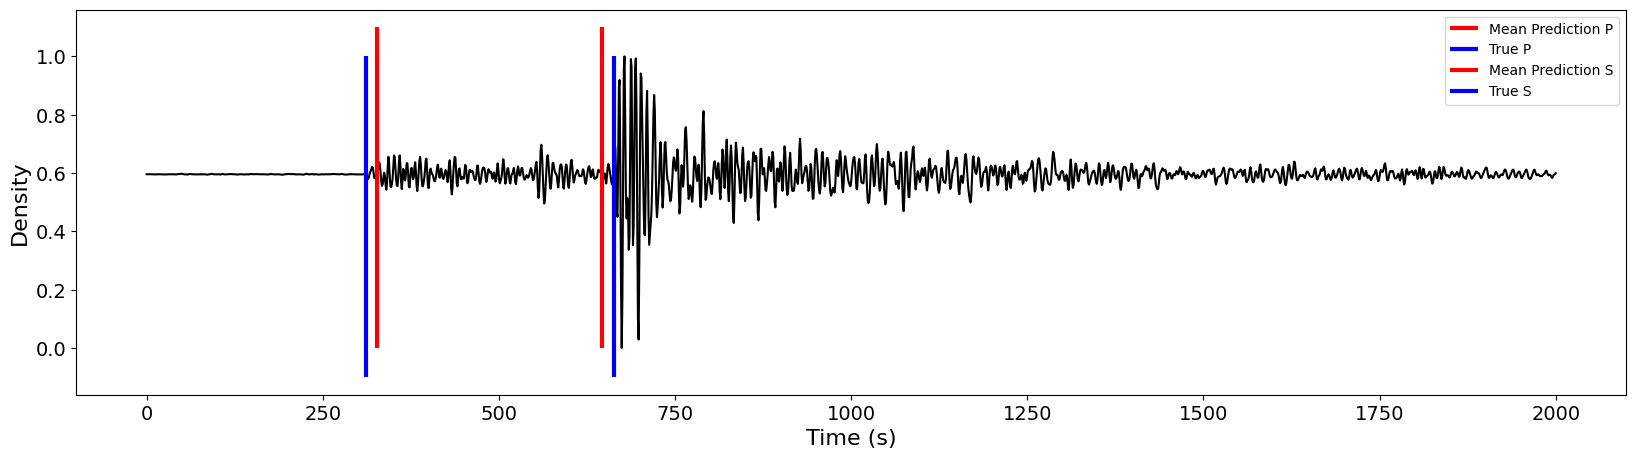

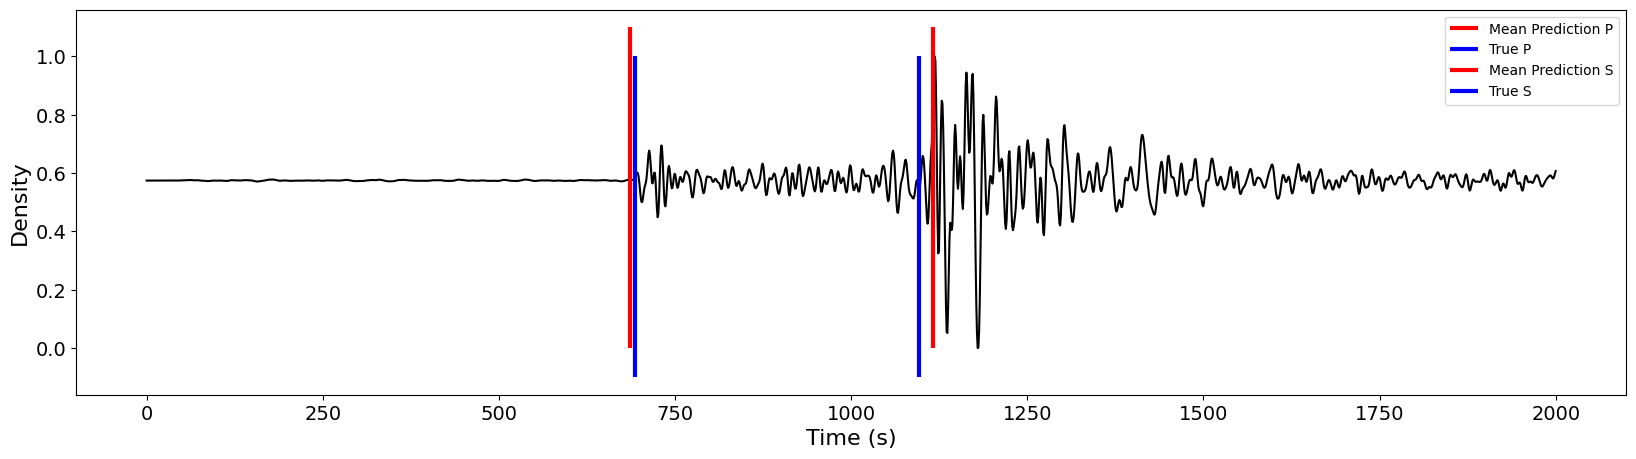

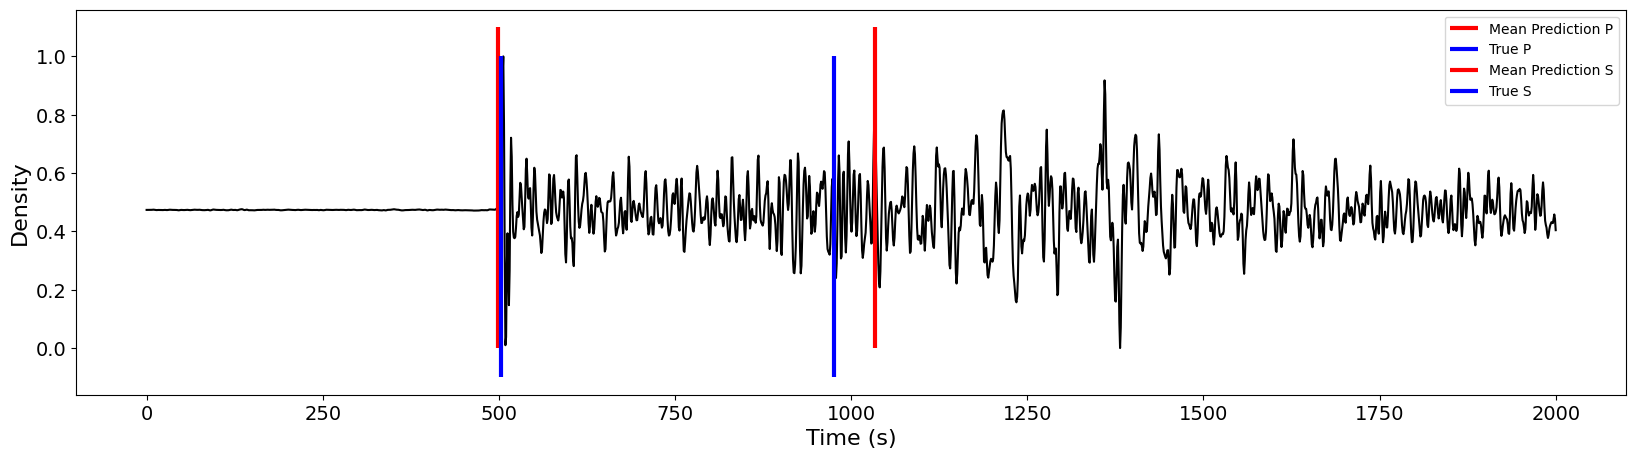

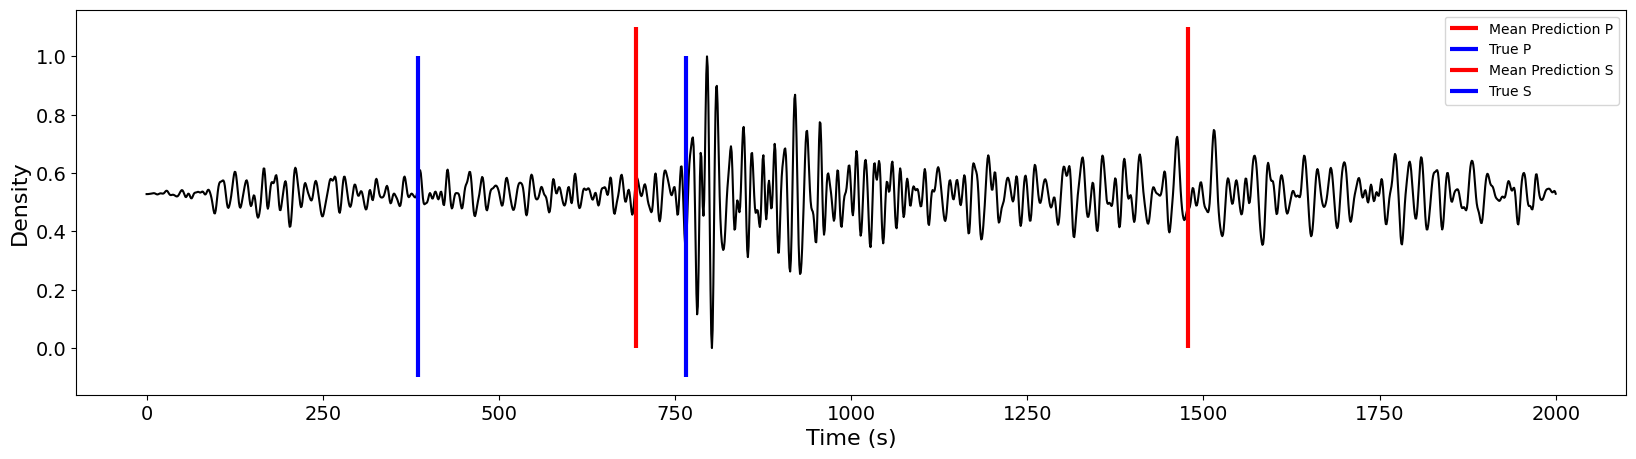

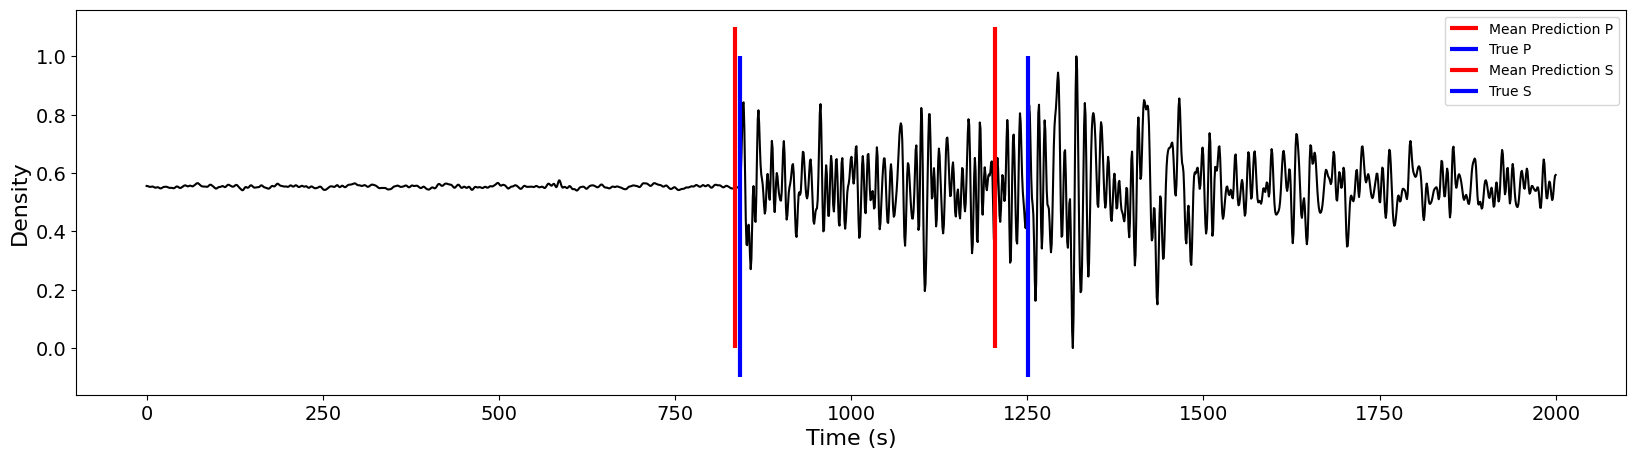

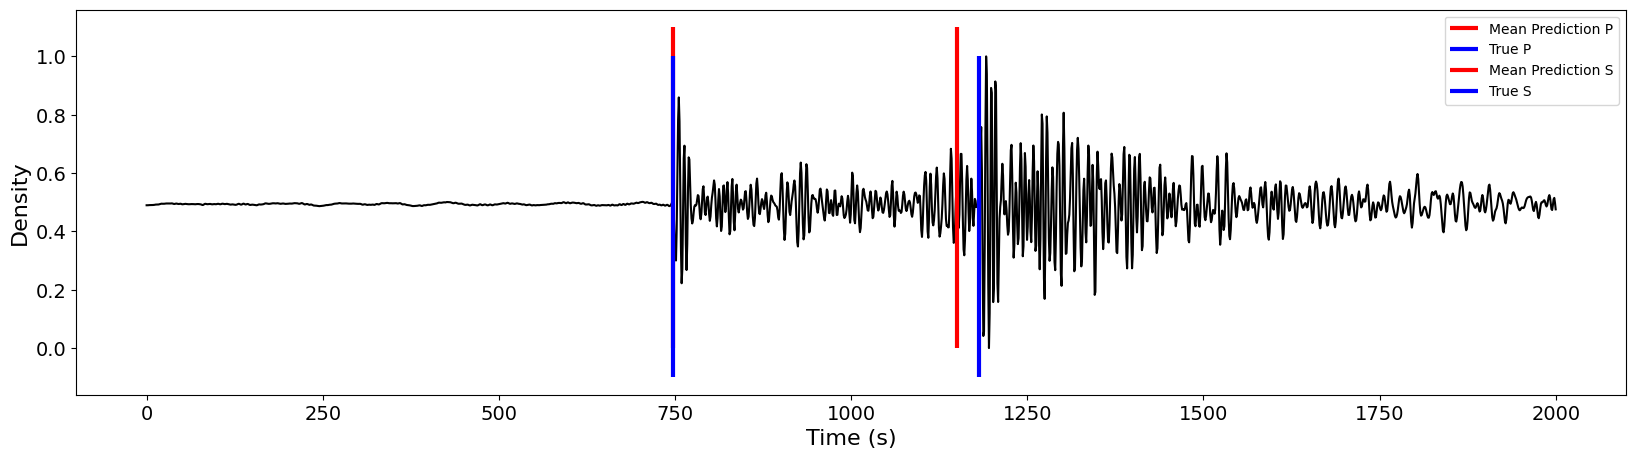

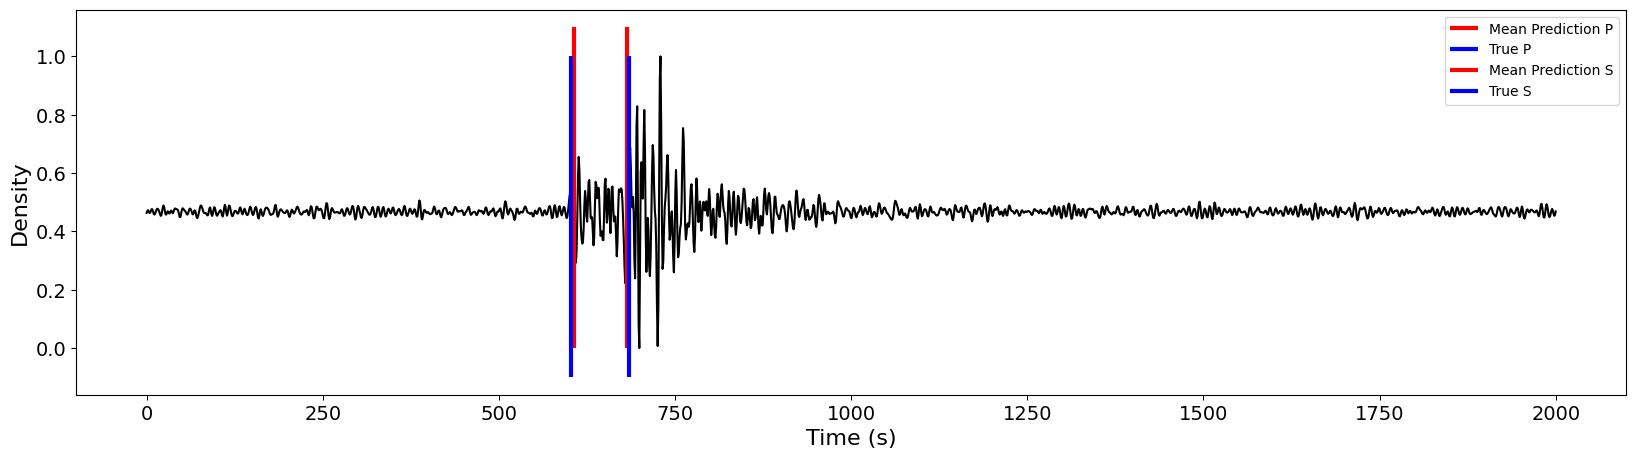

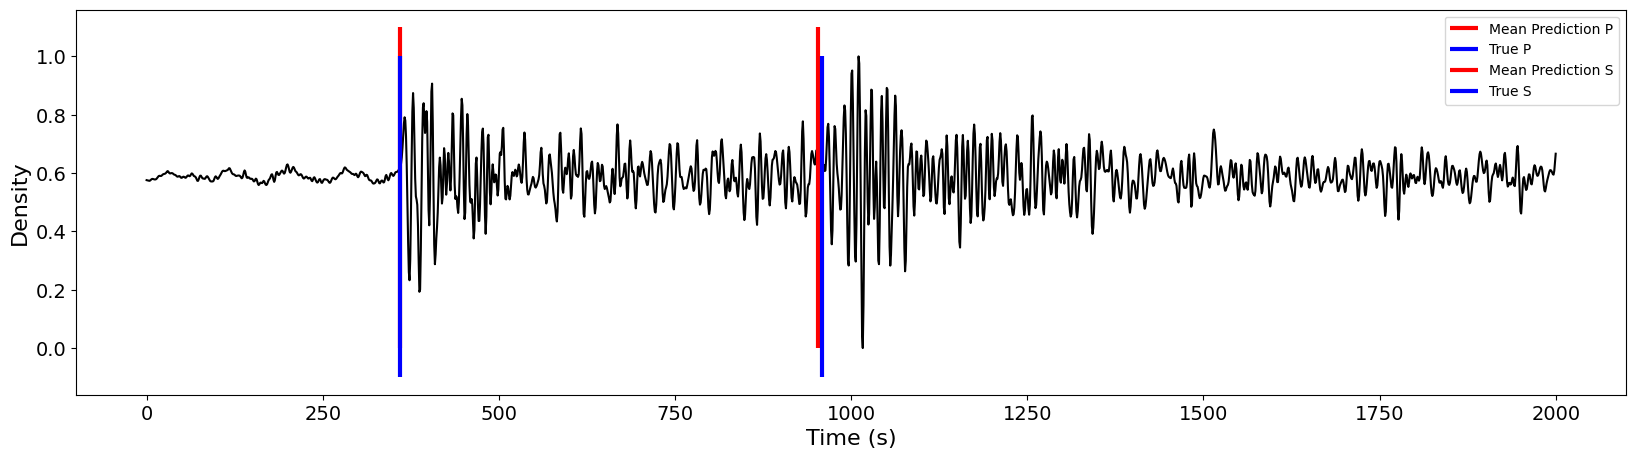

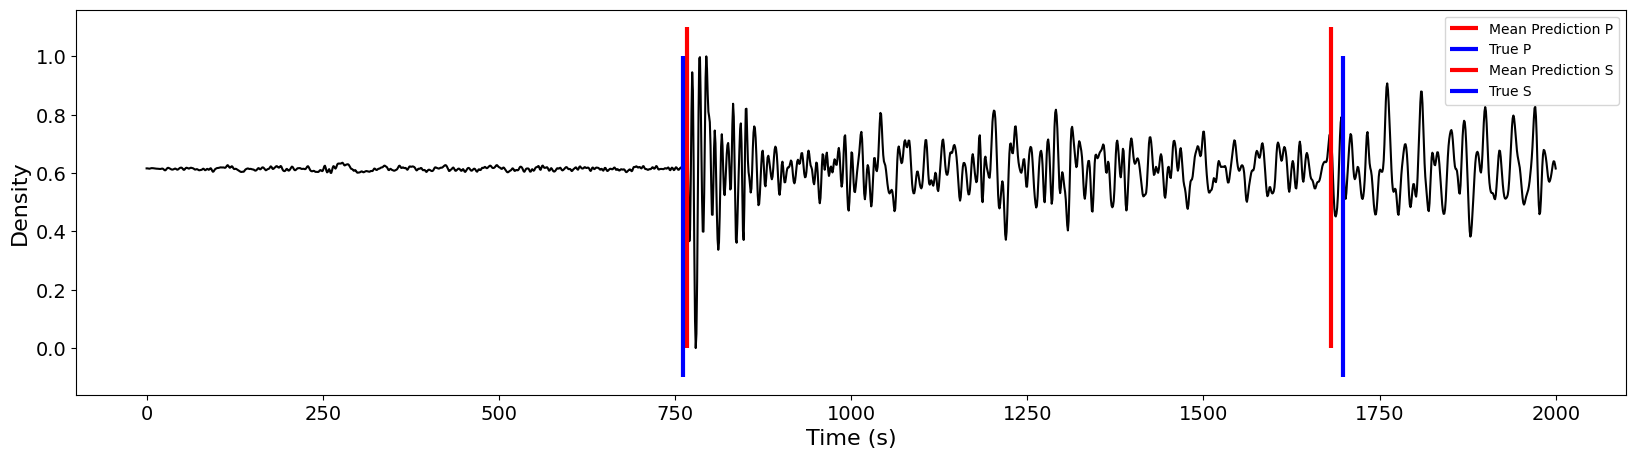

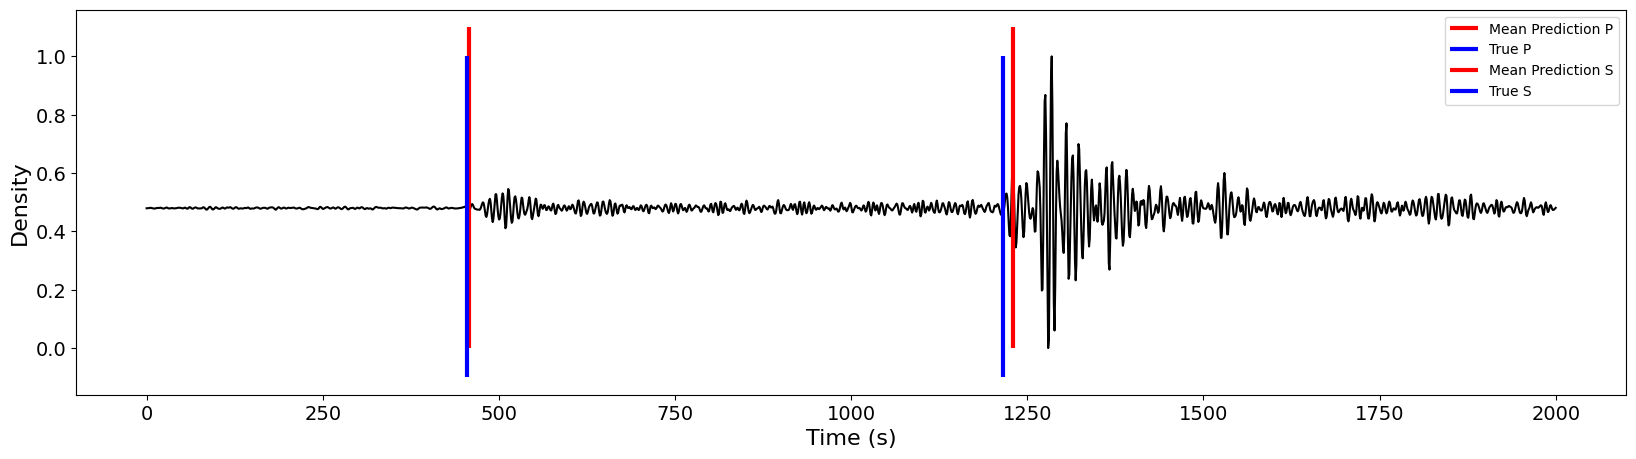

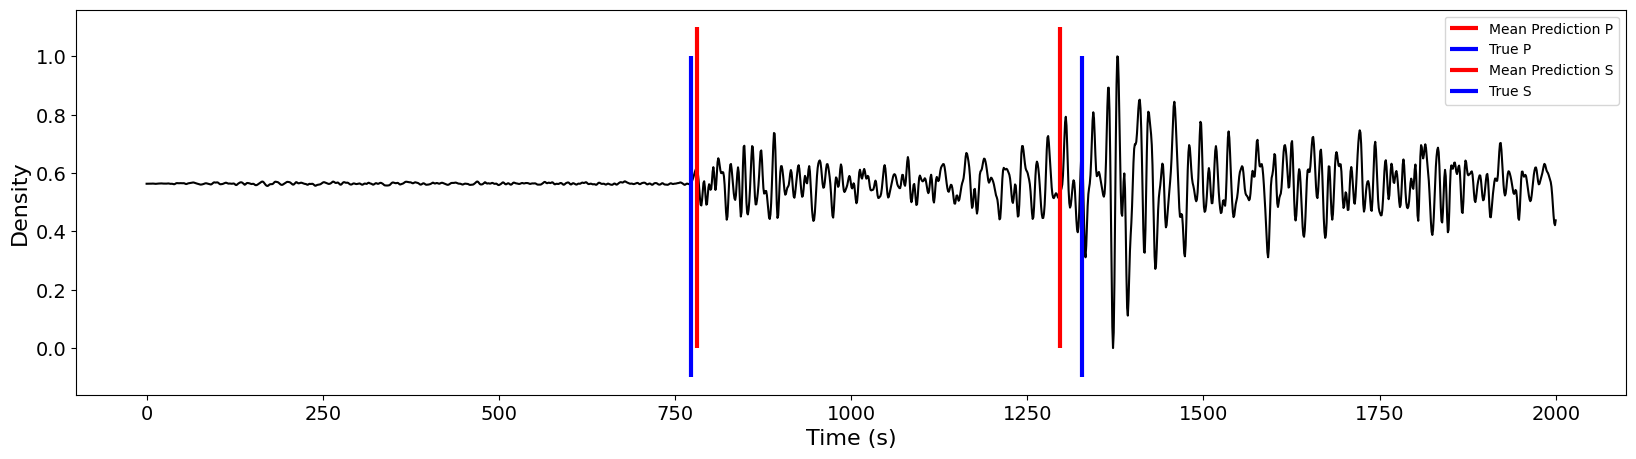

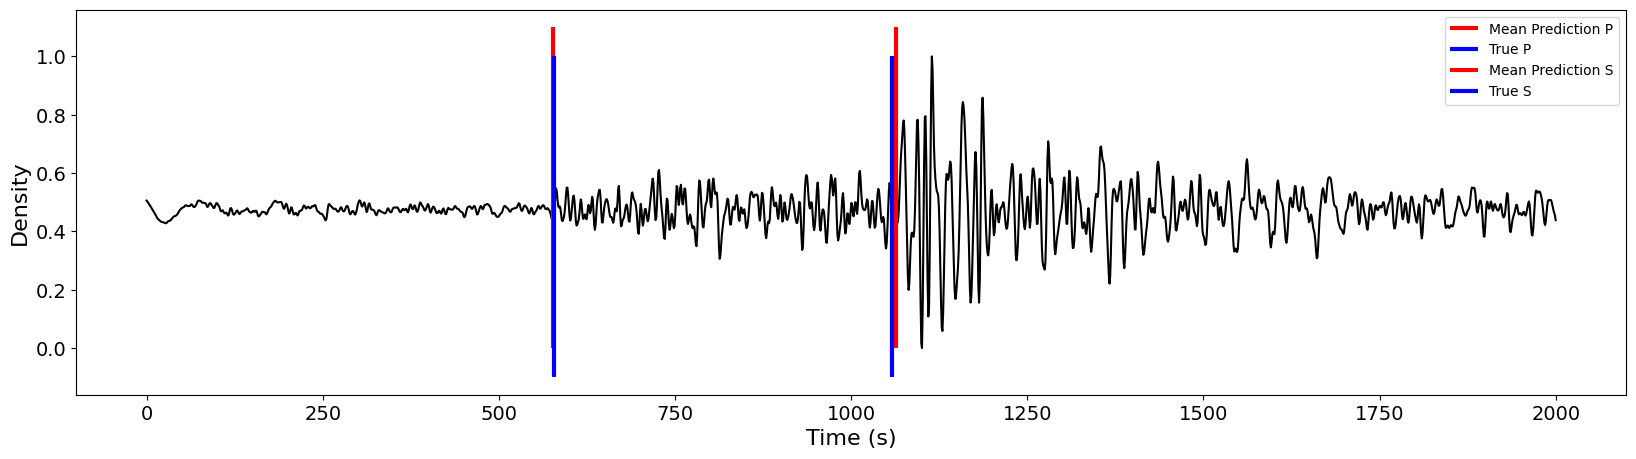

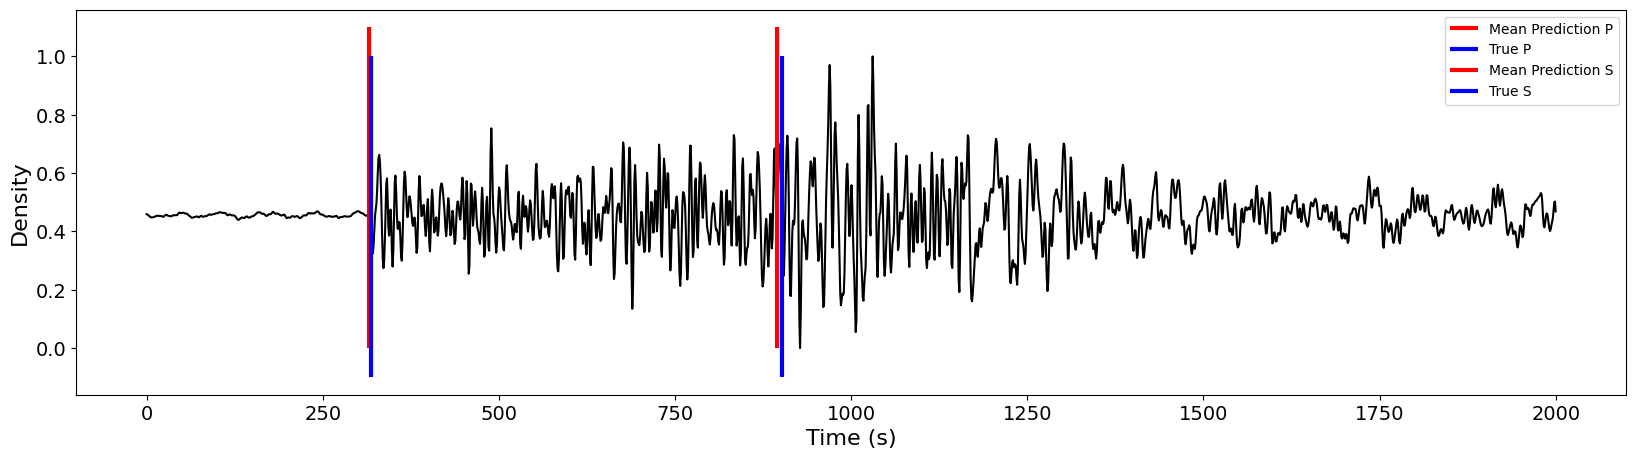

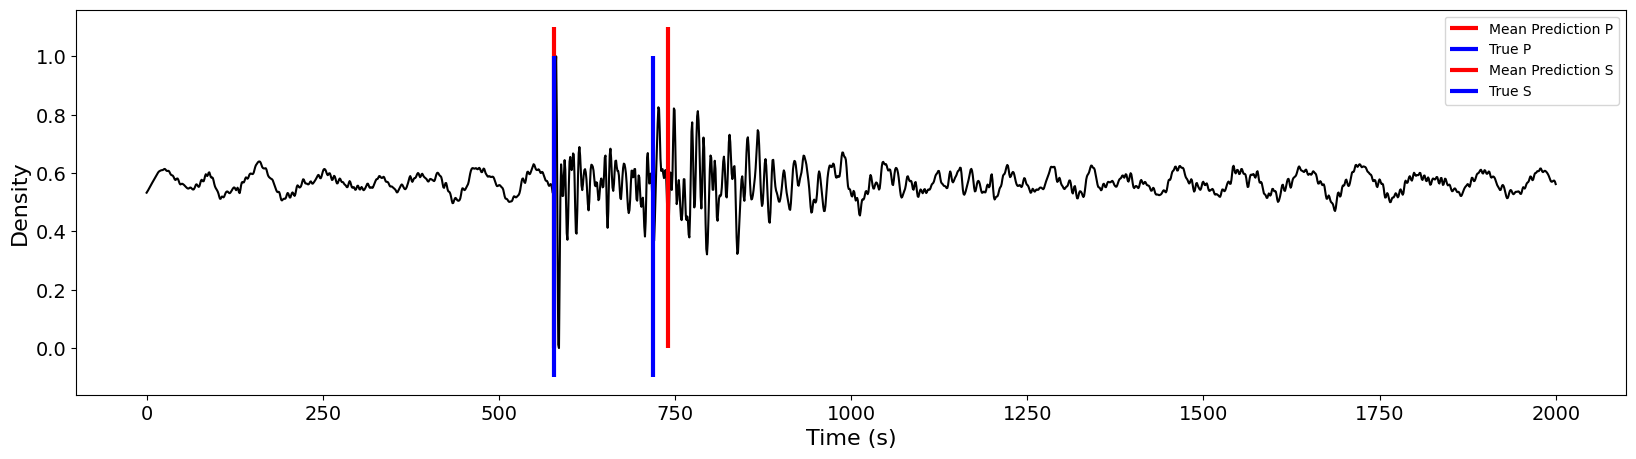

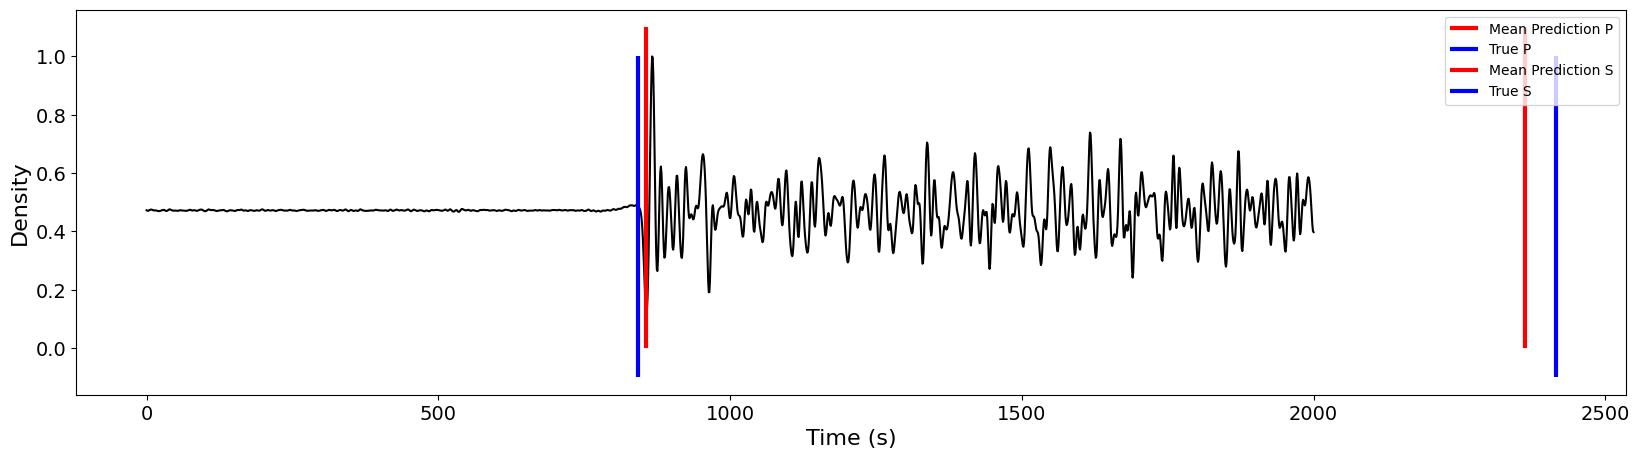

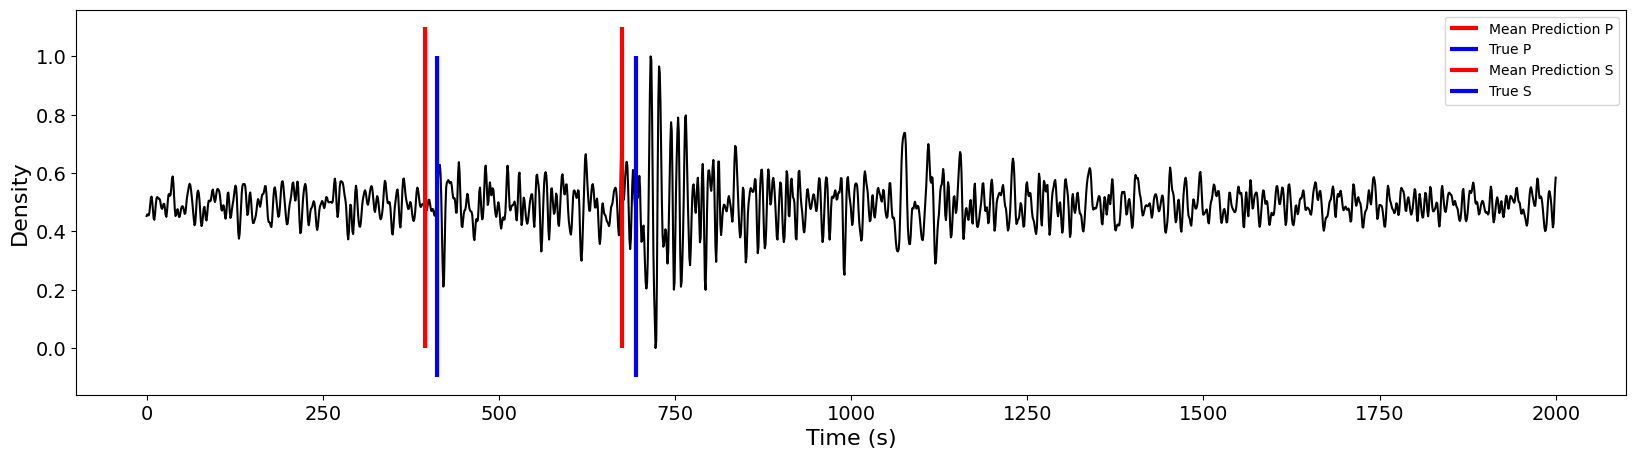

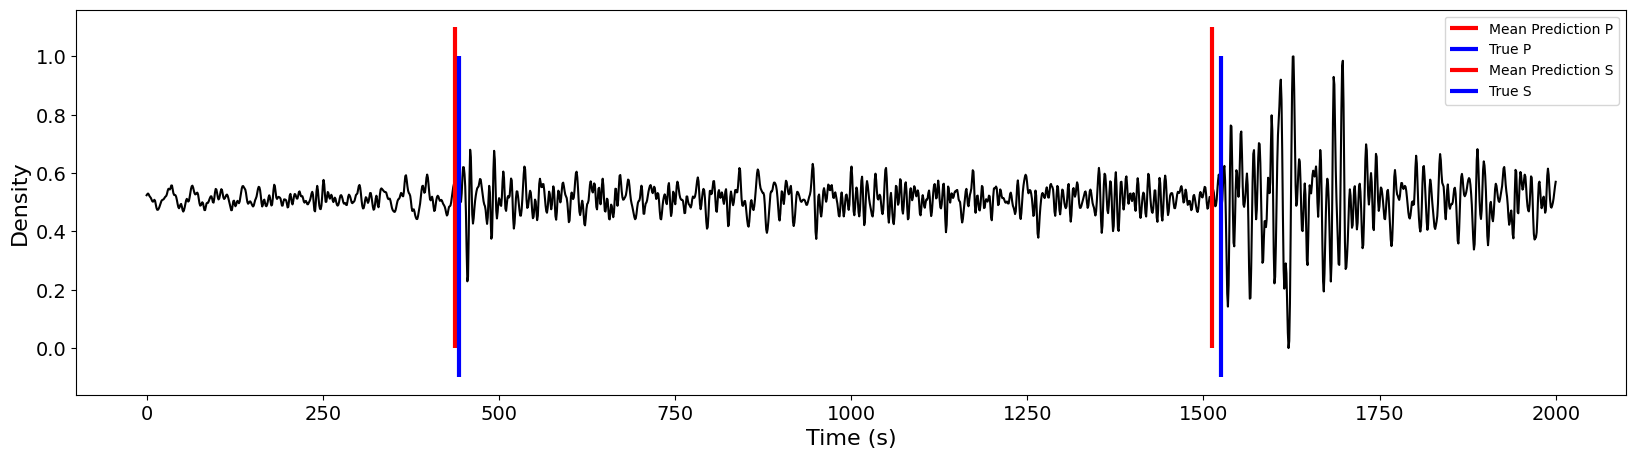

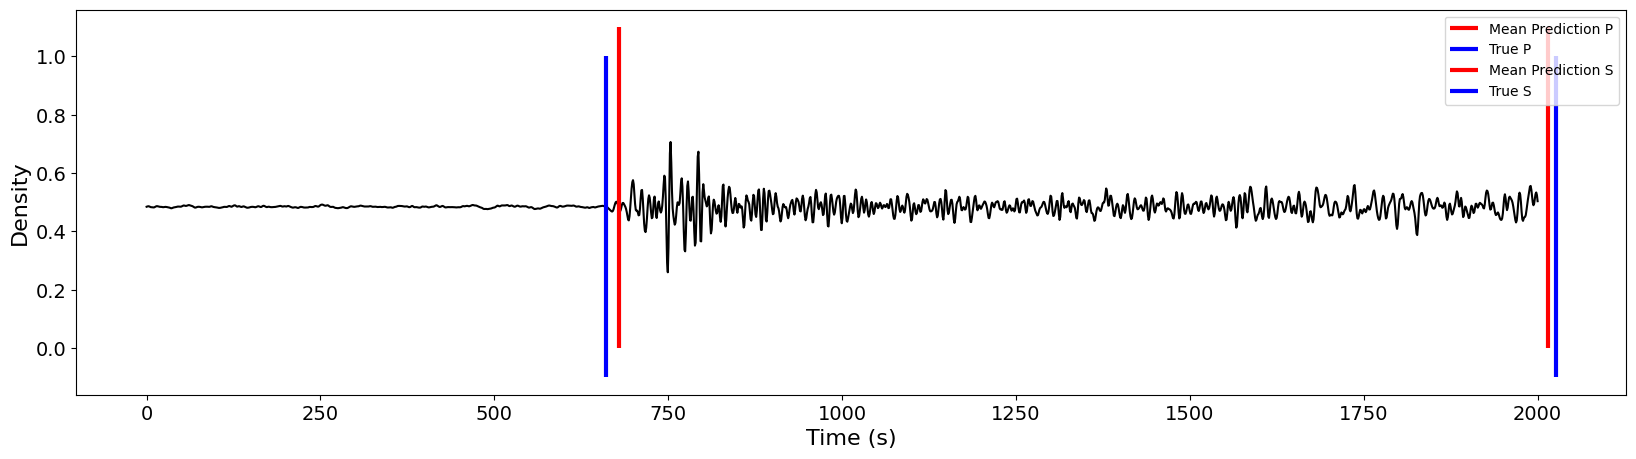

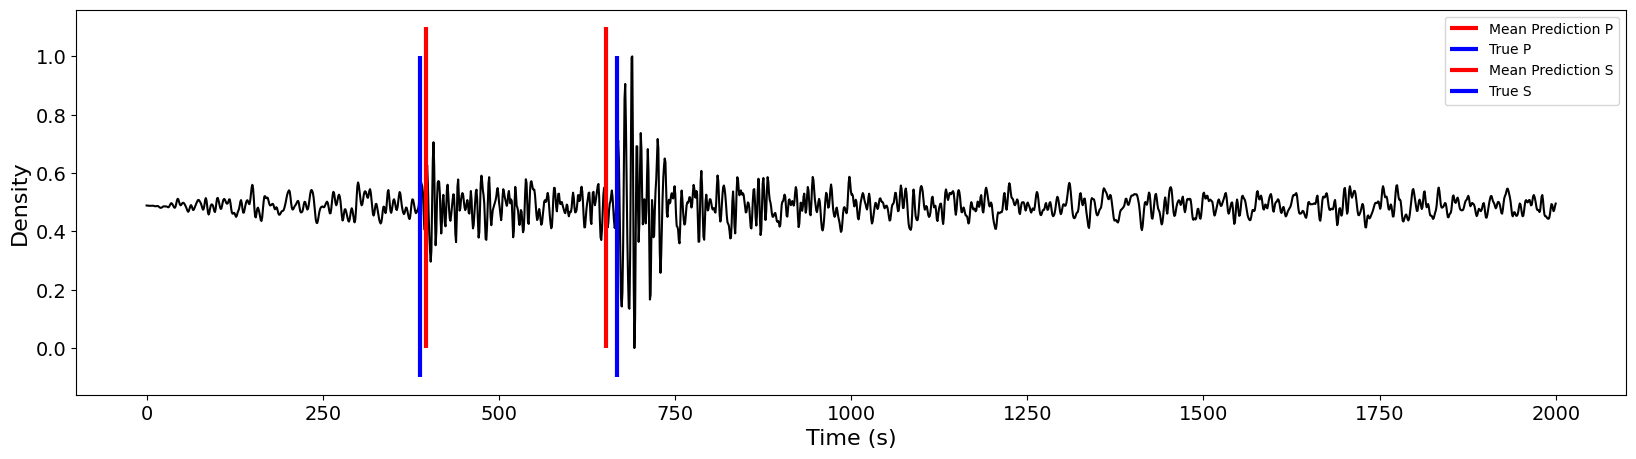

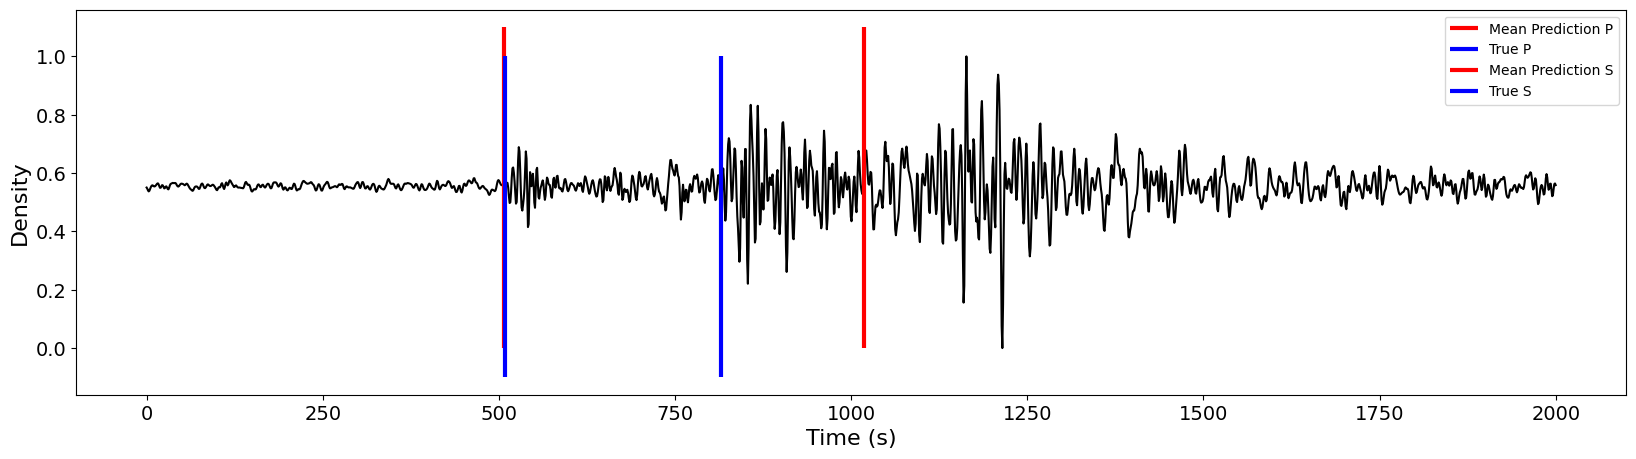

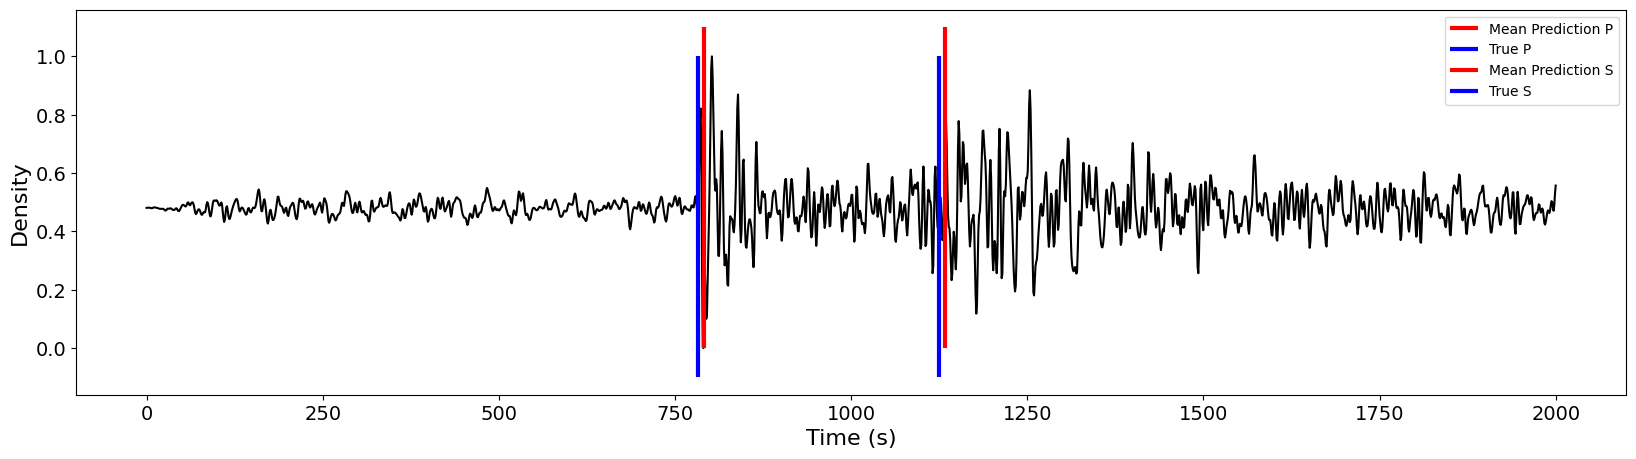

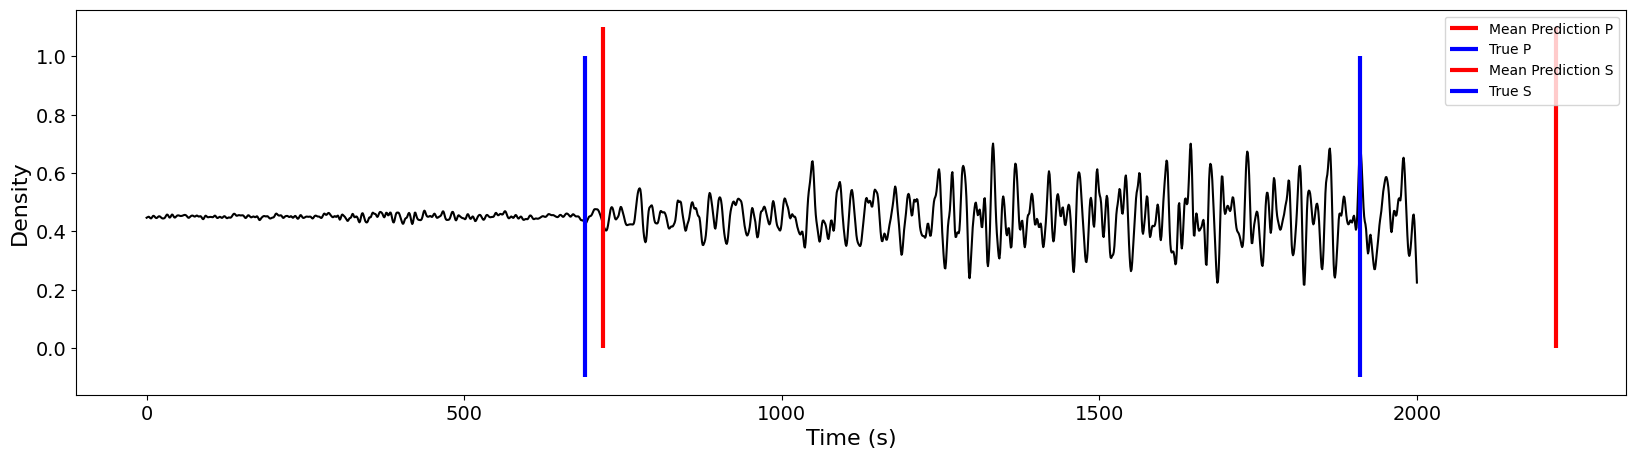

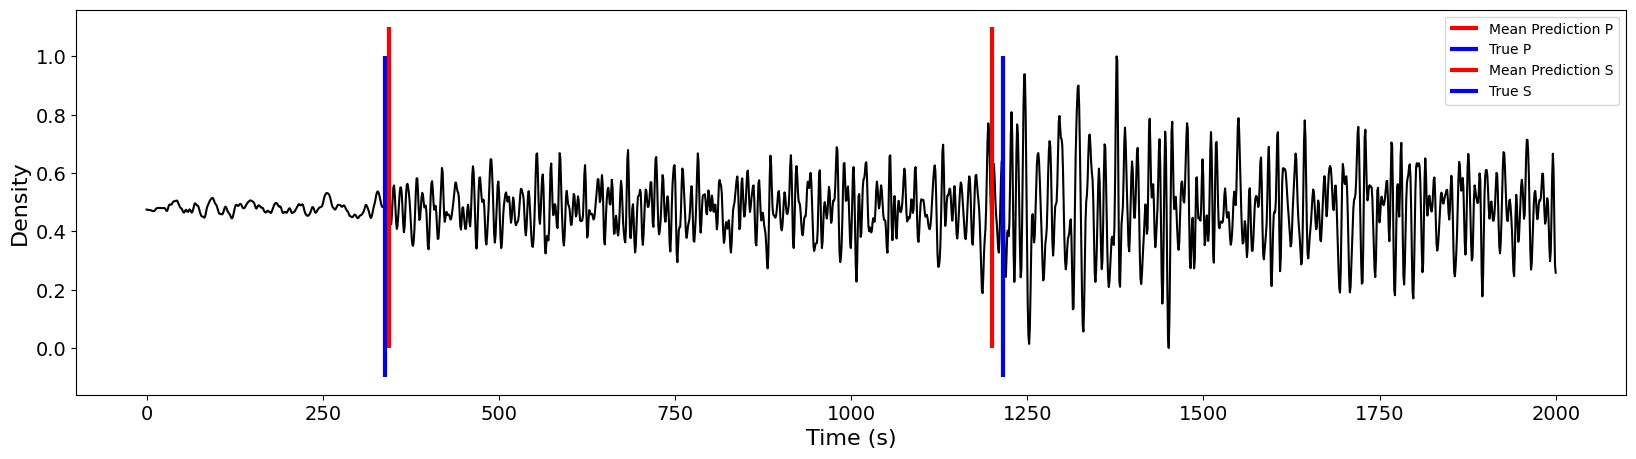

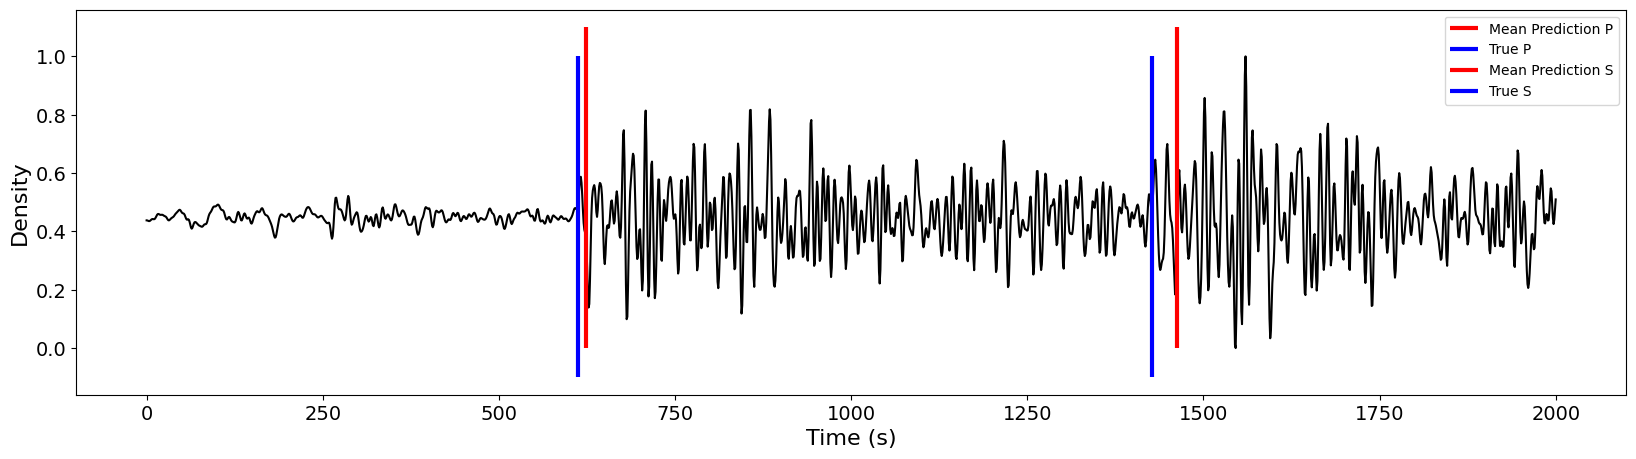

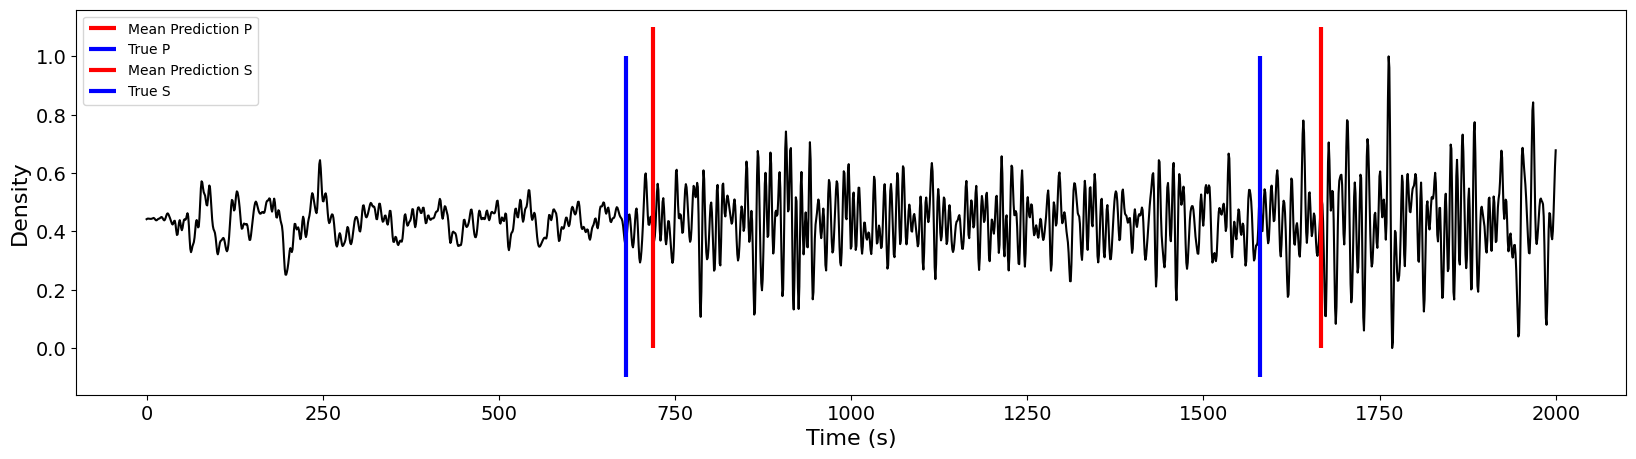

In [25]:
waves = waves.to(device)

preds = model(waves)

min = 0
max = 2000 

x = np.linspace(start=min, stop=max, num=max-min)

for i in range(32):
    # Creating the primary axis for the wave and vertical lines
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # Plotting the wave
    ax1.plot(x, waves[i,0,min:max].detach().cpu().numpy(), 'k')
    ax1.set_xlabel('Time (s)', fontsize=16)
    ax1.set_ylabel('Density', color='k', fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.vlines(preds[i,0].detach().cpu().numpy(), ymax=1.1, ymin=0, colors="r", label="Mean Prediction P", linewidth=3) #linestyles="--")
    ax1.vlines(labels[i,0], ymax=1, ymin=-0.1, colors="b", label="True P", linewidth=3) #linestyles="--")
    ax1.vlines(preds[i,1].detach().cpu().numpy(), ymax=1.1, ymin=0, colors="r", label="Mean Prediction S", linewidth=3) #linestyles="--")
    ax1.vlines(labels[i,1], ymax=1, ymin=-0.1, colors="b", label="True S", linewidth=3) #linestyles="--")
    ax1.legend()

